In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Dataset loading and converted in csv
df = pd.read_excel('/kaggle/input/customer-satisfaction/satisfaction.xlsx')
df.to_csv('/kaggle/working/satisfaction.csv', index=False)

In [3]:
# Dataset loading
df = pd.read_csv('/kaggle/working/satisfaction.csv')

print("Number of initial rows: ", df.shape[0])
print("\n", df.head())

Number of initial rows:  129880

        id satisfaction_v2  Gender   Customer Type  Age   Type of Travel  \
0   11112       satisfied  Female  Loyal Customer   65  Personal Travel   
1  110278       satisfied    Male  Loyal Customer   47  Personal Travel   
2  103199       satisfied  Female  Loyal Customer   15  Personal Travel   
3   47462       satisfied  Female  Loyal Customer   60  Personal Travel   
4  120011       satisfied  Female  Loyal Customer   70  Personal Travel   

      Class  Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0       Eco              265             0                                  0   
1  Business             2464             0                                  0   
2       Eco             2138             0                                  0   
3       Eco              623             0                                  0   
4       Eco              354             0                                  0   

   ...  Online support  Ease

In [4]:
# Conversion of nominal features into numerical ones
# (needed also because after pre-processing step Mutual Information works with numbers)
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
        
print(df.head())

       id  satisfaction_v2  Gender  Customer Type  Age  Type of Travel  Class  \
0   11112                1       0              0   65               1      1   
1  110278                1       1              0   47               1      0   
2  103199                1       0              0   15               1      1   
3   47462                1       0              0   60               1      1   
4  120011                1       0              0   70               1      1   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  ...  \
0              265             0                                  0  ...   
1             2464             0                                  0  ...   
2             2138             0                                  0  ...   
3              623             0                                  0  ...   
4              354             0                                  0  ...   

   Online support  Ease of Online booking  On-board serv

In [5]:
# Look for the number of missing values in each column
missing_values = df.isnull().sum()
print("Number of missing values per column: \n", missing_values)

Number of missing values per column: 
 id                                     0
satisfaction_v2                        0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in M

As shown, only 'Arrival Delay in Minutes' feature has missing values.
Since its value could depend on different factor in the real life, it was chosen to drop those rows containing them, also considering they're quite few.

In [6]:
# Drop those rows
df = df.dropna()
print("Number of rows after dropping missing values: ", df.shape[0])

Number of rows after dropping missing values:  129487


In [7]:
# Usage of a single type per delay
print("Departure Delay in Minutes type (before): ", df['Departure Delay in Minutes'].dtype)
print("Arrival Delay in Minutes type (before): ", df['Arrival Delay in Minutes'].dtype)

df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype('int', )

print("Departure Delay in Minutes type (after): ", df['Departure Delay in Minutes'].dtype)
print("Arrival Delay in Minutes type (after): ", df['Arrival Delay in Minutes'].dtype)

Departure Delay in Minutes type (before):  int64
Arrival Delay in Minutes type (before):  float64
Departure Delay in Minutes type (after):  int64
Arrival Delay in Minutes type (after):  int64


In [8]:
# Renaming of satisfaction (for semplicity)
df.rename(columns={'satisfaction_v2': 'Satisfaction'}, inplace=True)

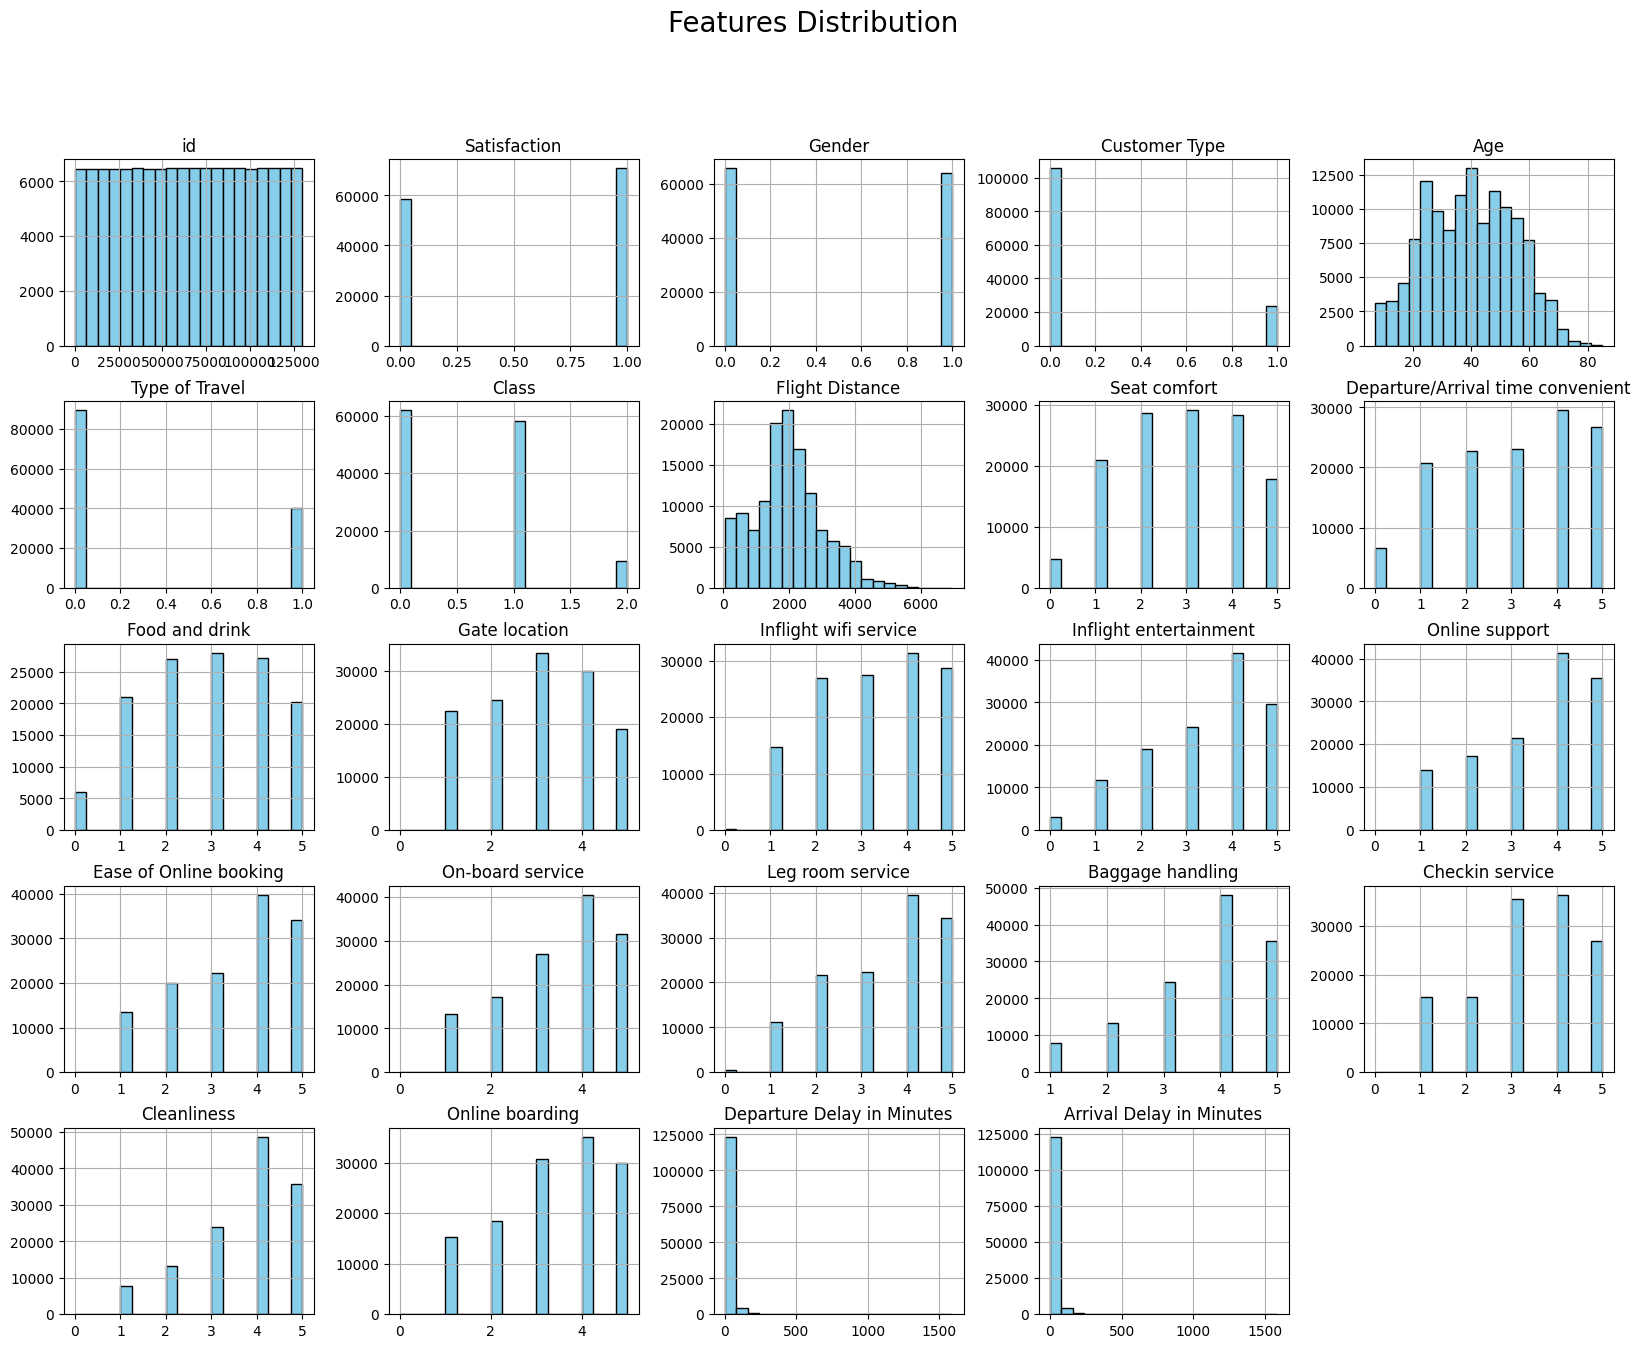

In [9]:
# Visualization of features distribution
df.hist(figsize=(20, 15), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Features Distribution', fontsize=20)
plt.show()

As shown, the target class 'Satisfaction' is quite balanced. Then, different factors are considered while providing an opinion of the overall airline passenger's satisfaction. Moreover, taking into account all the 129k surveys, in almost all cases delays were recorded as 0 minutes, indicating that the majority of flights arrived on time.

In [10]:
# Saving of modifications applied
df.to_csv('/kaggle/working/PassengerSatisfaction(afterPreProc).csv', index=False)

***2) IDENTIFICATION OF RELEVANT FEATURES***

In order to detect which features are the most relevant for our task, we compute the Mutual Information between each feature and the target one. 

Mutual information allows to quantify the dependency between two given factors, that means quantifying how much information we gain with respect to a variable, knowing another one. Then, it allows us to sort the final results and choose the most relevant ones.

In [11]:
from sklearn.feature_selection import mutual_info_classif

In [12]:
# Features and target one splitting
X = df.drop('Satisfaction', axis=1)
y = df['Satisfaction']

In [13]:
# Mutual Information computation
mutual_info = mutual_info_classif(X, y, discrete_features='auto')

# Dataframe creation
mutual_info_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mutual_info
})

# Features sorting with respect to their importance
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)

# Results' visualization
print(mutual_info_df)

                              Feature  Mutual Information
12             Inflight entertainment            0.160745
14             Ease of Online booking            0.112582
7                        Seat comfort            0.101945
13                     Online support            0.100641
20                    Online boarding            0.070361
15                   On-board service            0.068626
16                   Leg room service            0.063624
17                   Baggage handling            0.054016
19                        Cleanliness            0.052111
5                               Class            0.051589
2                       Customer Type            0.046118
18                    Checkin service            0.039616
11              Inflight wifi service            0.034288
6                     Flight Distance            0.030991
9                      Food and drink            0.029984
1                              Gender            0.027977
3             

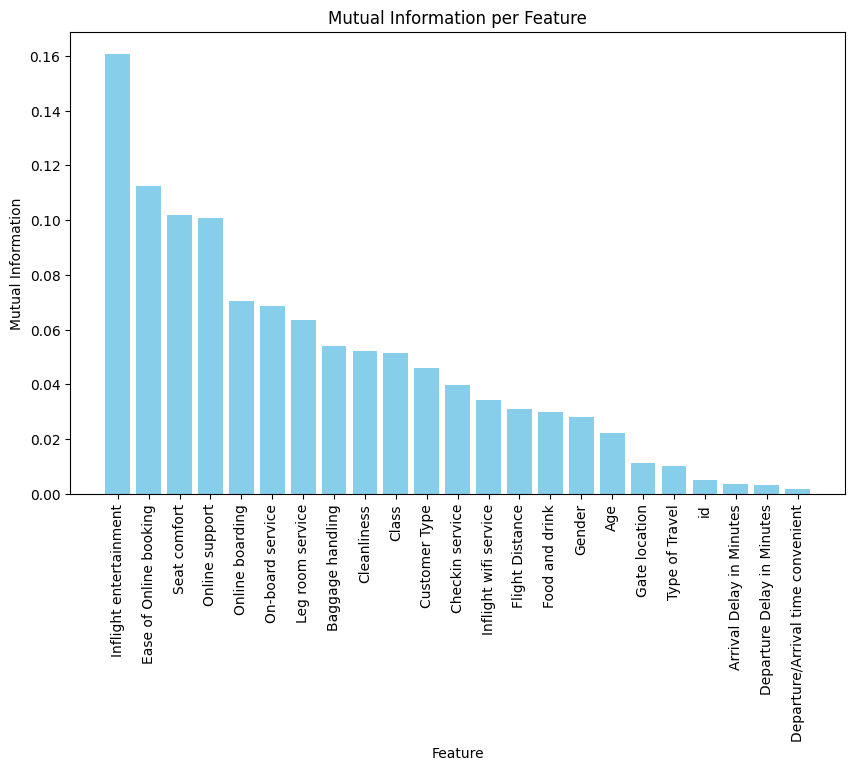

In [14]:
# Histogram plotting
plt.figure(figsize=(10, 6))
plt.bar(mutual_info_df['Feature'], mutual_info_df['Mutual Information'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.title('Mutual Information per Feature')
plt.xticks(rotation=90)
plt.show()

As shown by the histogram, the most relevant feature corresponds to 'Inflight entertainment', followed by 'Ease of Online booking', 'Online support', and 'Seat comfort'.
Whereas, all the others are gradually less influent, concluding with the various types of delays and, obviously, the id.

Even if it's intuitive to think of delay as one of the most important feature needed to evaluate the satisfaction of an airline, it's considered as the opposite probably because the greater part of tuples is described by a 0 value, meaning that almost always it is expected that there will not be delay, and therefore little information is gained.

Therefore, now we're going to pick relevant features only and separate them with respect to the target class.

In [15]:
# Relevant features
relevant = ['Inflight entertainment', 'Ease of Online booking', 'Online support', 'Seat comfort']
X = df[relevant]

# Target feature
y = df['Satisfaction']

print("Features (X):")
print(X.head())

print("\nTarget (y):")
print(y.head())

Features (X):
   Inflight entertainment  Ease of Online booking  Online support  \
0                       4                       3               2   
1                       2                       3               2   
2                       0                       2               2   
3                       4                       1               3   
4                       3                       2               4   

   Seat comfort  
0             0  
1             0  
2             0  
3             0  
4             0  

Target (y):
0    1
1    1
2    1
3    1
4    1
Name: Satisfaction, dtype: int64


***3) HYPERPARAMETER TUNING AND EVALUATION USING GRID SEARCH WITH STRATIFIED K-FOLD CROSS VALIDATION***

Now, we want to apply a Grid Search in order to find the best hyperparameters for each chosen model, maximizing the accuracy. It will be nested within a Stratified K Fold Cross Validation (with k=10), while using the previous models with their tuned hyperparameters. 

This phase is needed because nested cross-validation reduces the risk of overfitting by separating the hyperparameter tuning process from the final model evaluation. Moreover, K-Fold CV allows us to gain a more accurate estimate of the expected performances of each model.

The chosen models with their respective hyperparameters to tune are:

- KNN, with hyperparameters n_neighbors (number of nearest neighbors to consider when making predictions); weights (it determines how to weigh the contribution of each neighbor); metric (it specifies the distance metric used to find the nearest neighbors).

- Decision Tree, with hyperparameters max_depth (maximum depth of the tree); criterion (it measures the purity of each split).

- Random Forest, with hyperparameters n_estimators (number of trees in the forest); max_depth (maximum depth of each tree in the forest).

- Logistic Regression, with hyperparameters C (it controls the strength of regularization); penalty (ype of regularization applied to the model); solver (algorithm used to optimize the loss function (negative log likelihood)).

Note.
It was also tried to apply SVM. Nevertheless, even though many different alternatives to speedup and simplify the process were tried, it could not be possible to exploit it due to a too large complexity, unsuitable to be performed on these machines.

In the end, models performances will be evaluated and interpretated. Moreover, those considered as the most performing ones, will be compared also exploiting statistics tools like the paired t-test.

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_rel

In [17]:
# Training-Test sets splitting (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Definition of models to use and their respective hyperparameters to tune
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression()
}

param_grids = {
    'KNN': {
        'n_neighbors': [5, 7, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 15],
        'criterion':['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [15, 30, 50],
        'max_depth': [None, 10, 15]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

In [19]:
# Objects needed to apply a nested K-Fold Cross Validation
inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
results = {}
all_scores = {}

for model_name, model in models.items():
    print(f'Processing model: {model_name}')

    # GridSearchCV creation for the current model
    grid_search = GridSearchCV(model,
                               param_grids[model_name],
                               scoring='accuracy',
                               cv=inner,
                               n_jobs=-1) # Number of jobs to run in parallel (all processors here)

    # Application of outer CV
    scores = cross_validate(grid_search,
                            X_train,
                            y_train,
                            cv=outer,
                            scoring=scoring_metrics,
                            n_jobs=-1) # Number of jobs to run in parallel (all processors here)
    
    # Needed to access it afterwards
    all_scores[model_name] = scores
    
    print("Grid search ended...")

    # Convert results in a dataframe
    scores_df = pd.DataFrame(scores)
    final_results = pd.DataFrame()

    #  Mean and std computation of all folds
    scores_mean = scores_df.mean().values
    scores_std = scores_df.std().values

    # Result formatted in order to have an idea of the confidence interval
    formatted_results = [f'{round(mean, ndigits=3)} +/- {round(std, ndigits=3)}' for mean, std in zip(scores_mean, scores_std)]
    
    # Store results in dictionary
    results[model_name] = formatted_results

Processing model: KNN
Grid search ended...
Processing model: Decision Tree


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)


Grid search ended...
Processing model: Random Forest
Grid search ended...
Processing model: Logistic Regression
Grid search ended...


In [20]:
    # Adding new metrics given by CV
    scoring_metrics_cv = ['fit_time', 'score_time', 'accuracy', 'precision', 'recall', 'f1']
    
    # Convert the results dictionary to a DataFrame
    results_df = pd.DataFrame(results, index=scoring_metrics_cv).T
    results_df.index.name = 'Model'

    print(results_df)

                               fit_time       score_time         accuracy  \
Model                                                                       
KNN                  167.667 +/- 44.485  1.155 +/- 0.464  0.885 +/- 0.004   
Decision Tree           2.629 +/- 0.713  0.032 +/- 0.005   0.89 +/- 0.003   
Random Forest         55.067 +/- 13.566  0.141 +/- 0.079   0.89 +/- 0.003   
Logistic Regression      6.628 +/- 1.55  0.054 +/- 0.032  0.783 +/- 0.005   

                           precision           recall               f1  
Model                                                                   
KNN                  0.896 +/- 0.007   0.893 +/- 0.01  0.894 +/- 0.004  
Decision Tree        0.896 +/- 0.004  0.904 +/- 0.003    0.9 +/- 0.002  
Random Forest        0.896 +/- 0.004  0.904 +/- 0.003    0.9 +/- 0.003  
Logistic Regression  0.785 +/- 0.005   0.83 +/- 0.006  0.807 +/- 0.005  


Beyond their time computation, it was returned that KNN, Decision Tree and Random Forest were quite satisfying having good performances, near the 0.9 for almost all metrics. Therefore, they could be able to identify in the correct way positive and negative classes.

Even though Decision Tree and Random Forest performances are almost equivalent, we'd prefer Decision Tree because of its lower computational complexity and its greater interpretability with respect to the other one.

Whereas, Logistic Regression performances were the worst, indicating that it has lower capabilities of classifying in the correct way instances with respect to other models. Indeed, it could be due to its semplicity that leads to underfitting of data.

As regards the standard deviation, for most models it's very low, indicating stable performance across the different cross-validation folds. This suggests that models behave consistently on various data subsets. 


Now, we perform a paired t-test in order to compare the most performing models, defining if there are any significant improvement between them.

In [21]:
# Extract metrics' values for the three chosen models
knn_scores = all_scores['KNN']
decision_tree_scores = all_scores['Decision Tree']
random_forest_scores = all_scores['Random Forest']

# Comparison between KNN and Decision Tree
print("KNN vs Decision Tree:")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    t_stat, p_value = ttest_rel(knn_scores[metric], decision_tree_scores[metric])
    print(f"{metric}: t-statistic = {t_stat}, p-value = {p_value}")

print("\nKNN vs Random Forest:")
# Comparison between KNN and Random Forest
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    t_stat, p_value = ttest_rel(knn_scores[metric], random_forest_scores[metric])
    print(f"{metric}: t-statistic = {t_stat}, p-value = {p_value}")

print("\nDecision Tree vs Random Forest:")
# Comparison between Decision Tree and Random Forest
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    t_stat, p_value = ttest_rel(decision_tree_scores[metric], random_forest_scores[metric])
    print(f"{metric}: t-statistic = {t_stat}, p-value = {p_value}")

KNN vs Decision Tree:
test_accuracy: t-statistic = -6.418796618294384, p-value = 0.0001225383498270523
test_precision: t-statistic = -0.33414424199307546, p-value = 0.7459252164711905
test_recall: t-statistic = -2.9979342319764015, p-value = 0.015006549635899473
test_f1: t-statistic = -5.763666271974921, p-value = 0.0002715841341741794

KNN vs Random Forest:
test_accuracy: t-statistic = -6.265610927903213, p-value = 0.00014687307453791046
test_precision: t-statistic = 0.020675990351998165, p-value = 0.9839552581263777
test_recall: t-statistic = -3.0556626240052136, p-value = 0.013667147576407834
test_f1: t-statistic = -5.625170858976178, p-value = 0.00032368748833103264

Decision Tree vs Random Forest:
test_accuracy: t-statistic = 1.8914873036782816, p-value = 0.0911194672145617
test_precision: t-statistic = 3.0548486481571127, p-value = 0.013685151585965564
test_recall: t-statistic = -2.2037226163664343, p-value = 0.05500560995850517
test_f1: t-statistic = 0.7841612916403776, p-value 

Considering the KNN vs Decision Tree comparison:
- Accuracy: Since the p-value is 0.00012 (less than 0.05 at confidence level of 95%), it indicates a statistically significant difference. Since the t-statistic is negative, the Decision Tree is likely more accurate than KNN.
- Precision: The t-statistic is -0.33 with a p-value of 0.745, showing no significant difference in precision between the two models.
- Recall: Since the p-value is 0.015, (less than 0.05 at confidence level of 95%), it suggests a significant difference in recall. The negative t-statistic implies that the Decision Tree has higher recall than KNN.
- F1-score: Since the p-value is 0.00027, (less than 0.05 at confidence level of 95%), meaning a significant difference in F1-score, with the Decision Tree likely performing better.

Considering the KNN vs Random Forest comparison:
- Accuracy: Since the p-value is 0.00014 (less than 0.05 at a confidence level of 95%), it indicates a statistically significant difference. Since the t-statistic is negative, Random Forest is likely more accurate than KNN.
- Precision: The t-statistic is 0.02 with a p-value of 0.983, showing no significant difference in precision between the two models.
- Recall: Since the p-value is 0.013 (less than 0.05 at a confidence level of 95%), it suggests a significant difference in recall. The negative t-statistic implies that Random Forest has higher recall than KNN.
- F1-score: Since the p-value is 0.00032 (less than 0.05 at a confidence level of 95%), it indicates a significant difference in F1-score, with Random Forest likely performing better.

Considering Decision Tree vs Random Forest comparison:
- Accuracy: The p-value is 0.091 (greater than 0.05), indicating no statistically significant difference in accuracy between Decision Tree and Random Forest.
- Precision: Since the p-value is 0.013 (less than 0.05 at a confidence level of 95%), it suggests a significant difference in precision. The positive t-statistic indicates that Random Forest has higher precision than Decision Tree.
- Recall: Since the p-value is 0.055 (greater than 0.05), indicating no statistically significant difference in Recall between Decision Tree and Random Forest.
- F1-score: The p-value is 0.453 (greater than 0.05), showing no significant difference in F1-score between the two models.

In conclusion we have that
- Decision Tree vs KNN: Decision Tree is significantly better in accuracy, recall, and F1-score, but not in precision.
- Random Forest vs KNN: Random Forest outperforms KNN in accuracy, recall, and F1-score, but there is no difference in precision.
- Decision Tree vs Random Forest: No significant difference in accuracy, Recall F1-score, but Random Forest has better precision.

***4) PERFORMANCES EVALUATION AND MODELS COMPARISON***

Finally, we want to use the best models defined previously and exploit their tuned hyperparameters in order to fit them and evaluate them through precision-recall and ROC curves.

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Starting Grid Search for Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None}


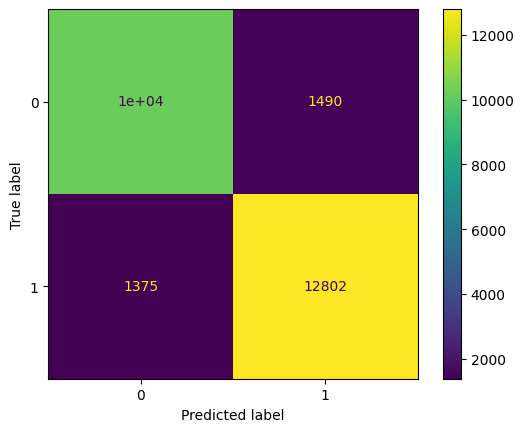

In [23]:
# Decision Tree GridSearch with model fitting
print("Starting Grid Search for Decision Tree...")

dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                              param_grid={
                                  'max_depth': [None, 10, 15],
                                  'criterion': ['gini', 'entropy']
                              },
                              cv=None,  # k=5 stratified K-Fold CV (following doc)
                              scoring='accuracy',
                              n_jobs=-1)

dt_grid_search.fit(X_train, y_train) # it will represent our decision tree model
print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")

# Confusion Matrix visualization
dt_pred_test = dt_grid_search.predict(X_test)
cm_dt_test = confusion_matrix(y_test, dt_pred_test)
ConfusionMatrixDisplay(cm_dt_test).plot()
plt.show()

Interpretation:
- True Negatives (TN): The model correctly predicted 10,000 samples as 0 (negative class) and their true value was indeed 0.

- False Positives (FP): The model predicted 1 (positive class) for 1,490 samples that were actually 0. This is an error because the model misclassified some samples as positive.

- False Negatives (FN): The model predicted 0 (negative class) for 1,375 samples that were actually 1. This is an error because the model failed to recognize these samples as positive.

- True Positives (TP): The model correctly predicted 12,802 samples as 1 (positive class) and their true value was indeed 1.

Starting Grid Search for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 30}


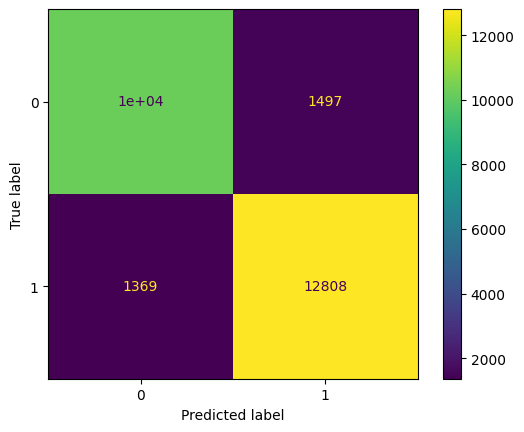

In [24]:
# Random Forest GridSearch with model fitting
print("Starting Grid Search for Random Forest...")

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid={
                                  'n_estimators': [15, 30, 50],
                                  'max_depth': [None, 10, 15]
                              },
                              cv=5,  # Usa una cross-validation k=5
                              scoring='accuracy',
                              n_jobs=-1)

rf_grid_search.fit(X_train, y_train) # it will represent our random forest model
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")

# Confusion Matrix visualization
rf_pred_test = rf_grid_search.predict(X_test)
cm_rf_test = confusion_matrix(y_test, rf_pred_test)
ConfusionMatrixDisplay(cm_rf_test).plot()
plt.show()

Interpretation:
- True Negatives (TN): The model correctly predicted 10,000 samples as 0 (negative class) and their true value was indeed 0.

- False Positives (FP): The model predicted 1 (positive class) for 1,497 samples that were actually 0. This is an error because the model misclassified some samples as positive.

- False Negatives (FN): The model predicted 0 (negative class) for 1,369 samples that were actually 1. This is an error because the model failed to recognize these samples as positive.

- True Positives (TP): The model correctly predicted 12,808 samples as 1 (positive class) and their true value was indeed 1.

Looking at both confusion matrices compared we can say that:

The number of False Positives (incorrect predictions of class 1 when it was 0) is very similar between the two models (1,490 for Decision Tree vs 1,497 for Random Forest).

The number of False Negatives (incorrect predictions of class 0 when it was 1) is slightly better for Random Forest (1,369) compared to Decision Tree (1,375).

Random Forest has slightly more True Positives (12,808 compared to 12,802 for Decision Tree), which suggests that Random Forest has a slight advantage in recognizing positive samples compared to the Decision Tree.

Therefore, overall, Random Forest seems to perform slightly better at correctly recognizing positive class samples compared to the Decision Tree.

Now we're going to visualize ROC and Precision-recall curves exploiting their functionalities and then ending the comparison between the two models.

In [25]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

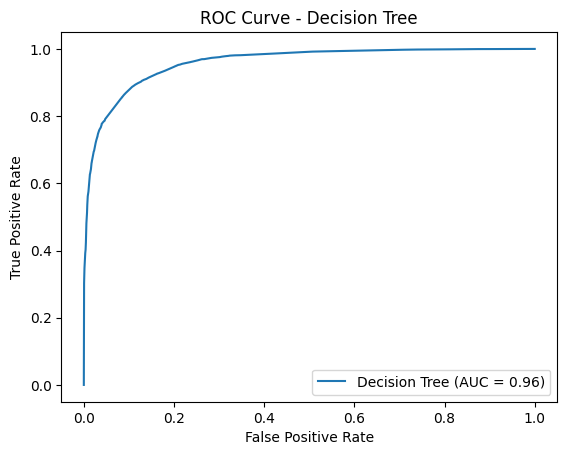

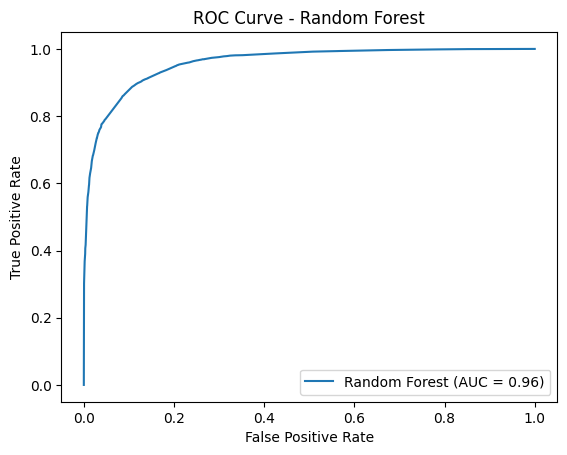

In [26]:
# Decision Tree ROC Curve
dt_prob_test = dt_grid_search.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob_test)
roc_auc_dt = auc(fpr_dt, tpr_dt) # area defining the model ability to distinguish classes

# Visualization
RocCurveDisplay(fpr=fpr_dt, tpr=tpr_dt, roc_auc=roc_auc_dt, estimator_name='Decision Tree').plot()
plt.title('ROC Curve - Decision Tree')
plt.show()


# Random Forest ROC Curve
rf_prob_test = rf_grid_search.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob_test)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Visualization
RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, estimator_name='Random Forest').plot()
plt.title('ROC Curve - Random Forest')
plt.show()

When interpreting ROC curves, the ideal curve would be positioned as close as possible to the top-left corner of the plot. This indicates a high True Positive Rate (sensitivity) and a low False Positive Rate (specificity).

Computing the various probabilities allows us to change the decision threshold of the model (the default is 50% - meaning that if a sample belongs to a class with a probability greater than that threshold, then it belongs to that class for sure), and visualize any possible situation the model could achieve.

In our analysis, both models exhibited identical performance across all possible thresholds. This suggests that the two models have learned essentially the same underlying function, as demonstrated in the subsequent comparison.

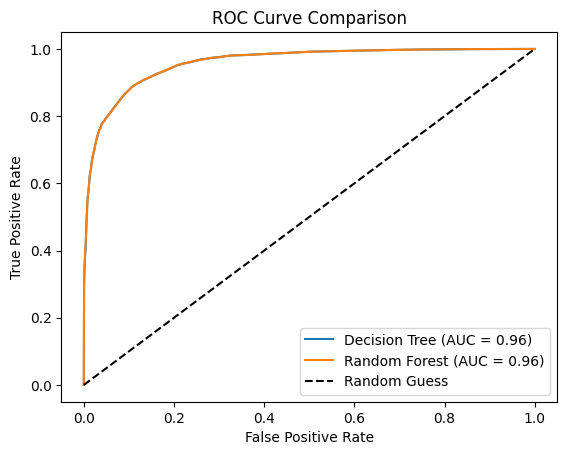

In [27]:
# Comparison between the two ROC curves
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

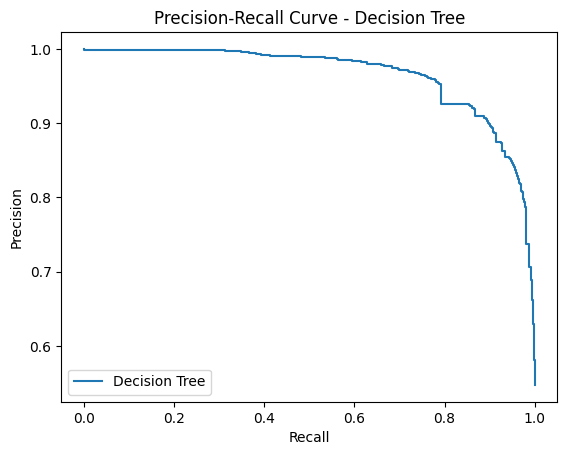

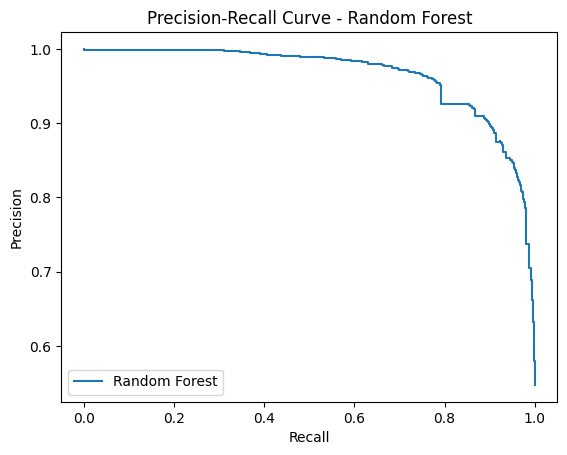

In [28]:
# Decision Tree Precision-Recall curve
precision_dt, recall_dt, _ = precision_recall_curve(y_test, dt_prob_test)

# Visualization
PrecisionRecallDisplay(precision=precision_dt, recall=recall_dt, estimator_name='Decision Tree').plot()
plt.title('Precision-Recall Curve - Decision Tree')
plt.show()


# Random Forest Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob_test)

# Visualization
PrecisionRecallDisplay(precision=precision_rf, recall=recall_rf, estimator_name='Random Forest').plot()
plt.title('Precision-Recall Curve - Random Forest')
plt.show()

When evaluating models using Precision-Recall curves, the goal is to maximize both Precision and Recall. Therefore, the ideal curve would be positioned as close as possible to the top-right corner of the plot.

As with the ROC curve analysis, this indicates that both models have learned essentially the same underlying function, as demonstrated in the subsequent comparison.

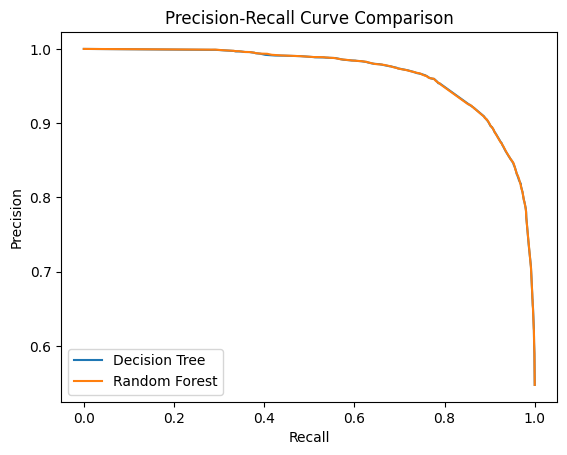

In [29]:
# Comparison between the two Precision-Recall curves
plt.plot(recall_dt, precision_dt, label='Decision Tree')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.show()

***5) CONCLUSIONS***

In conclusion, our analysis indicates that Decision Tree and Random Forest models outperformed Logistic Regression and KNN. However, t-tests revealed no statistically significant differences between Decision Tree and Random Forest. Indeed, their performance metrics and confusion matrices were remarkably similar. Furthermore, the final learning curves confirmed that both models essentially learned the same underlying function, resulting in identical curves.

Despite their comparable performance, we prefer the Decision Tree model due to its superior interpretability compared to Random Forest. Additionally, Decision Trees are generally less complex than Random Forests, making them more computationally efficient in certain scenarios.